In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sentiment_score_data = pd.read_csv('daily_sentiment_scores.csv')
tesla_data = pd.read_csv('historical stock data/tesla_price.csv')

In [299]:
sentiment_score_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             259 non-null    object 
 1   sentiment_score  259 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [301]:
tesla_data.head()

,Date,Close/Last,Volume,Open,High,Low
0,08/07/2024,$191.76,71159780,$200.77,$203.49,$191.48
1,08/06/2024,$200.64,73783940,$200.75,$202.90,$192.67
2,08/05/2024,$198.88,100308800,$185.22,$203.8799,$182.00
3,08/02/2024,$207.67,82880120,$214.88,$216.13,$205.78
4,08/01/2024,$216.86,83861900,$227.69,$231.867,$214.3328


In [303]:
tesla_data = tesla_data.iloc[::-1].reset_index(drop=True)

In [305]:
#reading the date column by converting to date time format
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

In [307]:
# Columns to be cleaned
columns_to_clean = ['Open', 'Close/Last', 'High', 'Low']

# Remove dollar signs and convert to numeric for each specified column
for column in columns_to_clean:
    tesla_data[column] = tesla_data[column].astype(str).str.replace('[$,]', '', regex=True)
    tesla_data[column] = pd.to_numeric(tesla_data[column], errors='coerce')
tesla_data.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2019-08-08,15.8867,79115195,15.6300,15.9867,15.5100
2019-08-09,15.6673,58473631,15.7369,15.9307,15.5873
2019-08-12,15.2673,69959020,15.5327,15.7180,15.2500
2019-08-13,15.6667,73034933,15.2540,15.7333,15.1700
2019-08-14,14.6413,143438793,15.4140,15.4333,14.4460


In [309]:
tesla_data = tesla_data.reset_index()
tesla_data = tesla_data.rename(columns={'Date': 'date'})
tesla_data['date'] = pd.to_datetime(tesla_data['date'])
sentiment_score_data['date'] = pd.to_datetime(sentiment_score_data['date'])

In [311]:
merged_data = tesla_data.merge(sentiment_score_data, on='date', how='inner')

In [313]:
#it is lower as stock market closes on saturday and sundays but news are still there
merged_data

,date,Close/Last,Volume,Open,High,Low,sentiment_score
0,2023-11-13,223.71,140447600,215.60,225.4000,211.6101,0.330390
1,2023-11-14,237.41,149771600,235.03,238.1350,230.7200,0.307546
2,2023-11-15,242.84,150354000,239.29,246.7000,236.4500,0.328068
3,2023-11-16,233.59,136816800,239.49,240.8800,230.9600,0.031015
4,2023-11-17,234.30,142766200,232.00,237.3900,226.5400,0.065156
...,...,...,...,...,...,...,...
174,2024-07-25,220.25,100636500,216.80,226.0000,216.2310,-0.315093
175,2024-07-26,219.80,94604150,221.19,222.2799,215.3300,0.274613
176,2024-07-29,232.10,129201800,224.90,234.2700,224.7000,0.189046
177,2024-07-30,222.62,100560300,232.25,232.4100,220.0000,-0.169089


In [315]:
correlation_matrix = merged_data.corr()

In [317]:
correlation_matrix

,date,Close/Last,Volume,Open,High,Low,sentiment_score
date,1.000000,-0.320577,-0.169563,-0.323753,-0.302215,-0.331342,-0.018960
Close/Last,-0.320577,1.000000,0.426837,0.987304,0.994469,0.995312,0.209663
Volume,-0.169563,0.426837,1.000000,0.412347,0.452416,0.393033,0.064111
Open,-0.323753,0.987304,0.412347,1.000000,0.994547,0.995251,0.184019
High,-0.302215,0.994469,0.452416,0.994547,1.000000,0.995218,0.198485
Low,-0.331342,0.995312,0.393033,0.995251,0.995218,1.000000,0.198346
sentiment_score,-0.018960,0.209663,0.064111,0.184019,0.198485,0.198346,1.000000


In [319]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 2. Data Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[['Close/Last', 'Volume', 'sentiment_score']])

In [321]:
# 3. Creating Input Sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 0])  # Assuming the first column is the 'Close' price
    return np.array(X), np.array(y)

time_steps = 5
X, y = create_sequences(scaled_data, time_steps)



In [323]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [325]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Building a simpler LSTM model without Dropout
model = Sequential()

# Adding the first LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding a second LSTM layer
model.add(LSTM(50, return_sequences=False))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                │ (None, 5, 50)         │       10,800 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm_21 (LSTM)                │ (None, 50)            │       20,200 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_10 (Dense)              │ (None, 1)             │           51 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

In [327]:

# Training the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), shuffle=False)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - loss: 0.2127 - val_loss: 0.1183
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0722 - val_loss: 0.0278
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0266 - val_loss: 0.0384
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0375 - val_loss: 0.0229
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0191 - val_loss: 0.0283
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0201 - val_loss: 0.0282
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0169 - val_loss: 0.0181
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0108 - val_loss: 0.0147
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0101 - val_loss: 0.0133
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - val_loss: 0.0145
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0064 - val_loss: 0.0136
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - val_loss: 0.0127


In [329]:
# Predicting on the test set
y_pred = model.predict(X_test)

# Inversing the scaling of the prediction and actual values for better interpretation
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), 2))), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 2))), axis=1))[:, 0]

# Evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print the metrics
print(f" Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
 Mean Squared Error (MSE): 174.4730633085299
Mean Absolute Error (MAE): 9.039972199486835
Mean Absolute Percentage Error (MAPE): 4.31%


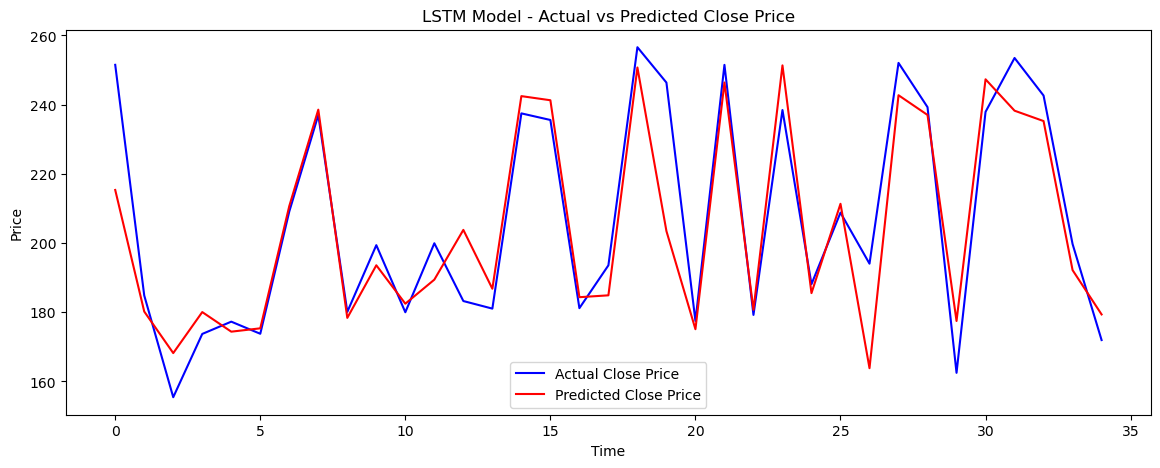

In [331]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual Close Price')
plt.plot(y_pred, color='red', label='Predicted Close Price')
plt.title('LSTM Model - Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [333]:
# 3. Creating Input Sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 0])  # Assuming the first column is the 'Close' price
    return np.array(X), np.array(y)

time_steps = 20
X, y = create_sequences(scaled_data, time_steps)


In [335]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [337]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Building a simpler LSTM model without Dropout
model = Sequential()

# Adding the first LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding a second LSTM layer
model.add(LSTM(50, return_sequences=False))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                │ (None, 20, 50)        │       10,800 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm_23 (LSTM)                │ (None, 50)            │       20,200 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_11 (Dense)              │ (None, 1)             │           51 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

In [339]:

# Training the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), shuffle=False)



Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - loss: 0.2324 - val_loss: 0.0769
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0476 - val_loss: 0.0514
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0566 - val_loss: 0.0271
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0288 - val_loss: 0.0324
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0310 - val_loss: 0.0369
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0307 - val_loss: 0.0253
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0229 - val_loss: 0.0225
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0225 - val_loss: 0.0241
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0217 - val_loss: 0.0211
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0196 - val_loss: 0.0218
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0200 - val_loss: 0.0209
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0187 - val_loss: 0.0201


In [341]:
# Predicting on the test set
y_pred = model.predict(X_test)

# Inversing the scaling of the prediction and actual values for better interpretation
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), 2))), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 2))), axis=1))[:, 0]

# Evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print the metrics
print(f" Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
 Mean Squared Error (MSE): 152.6572032016605
Mean Absolute Error (MAE): 9.465677648899142
Mean Absolute Percentage Error (MAPE): 4.71%


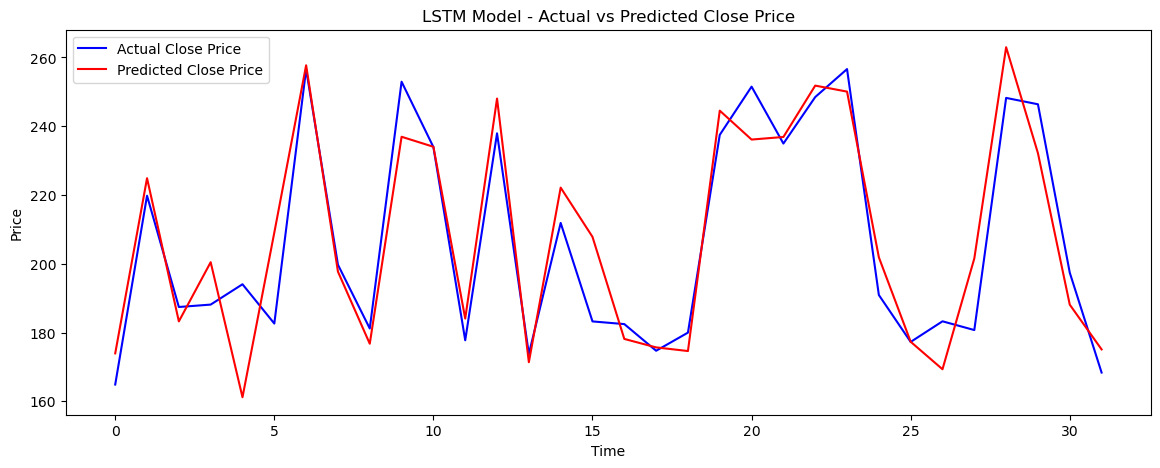

In [343]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual Close Price')
plt.plot(y_pred, color='red', label='Predicted Close Price')
plt.title('LSTM Model - Actual vs Predicted Close Price with 20 se')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()